In [105]:
from scipy.signal import chirp
import numpy as np
from matplotlib import pyplot as plt
import math
import os
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic")

import numpy as np
from matplotlib import pyplot as plt
import h5py
import DYNAPSETools.dynapseSpikesFitter as fitter

folderName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myoutputs/thesis_output_aedat/"


plt.close('all')

trainFileList = ['classificationBias_slowClassificationRes_seqPulse','baselineBias_classificationRes_seqPulse']


      

    
    

In [128]:
u = np.ones([1,5])


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

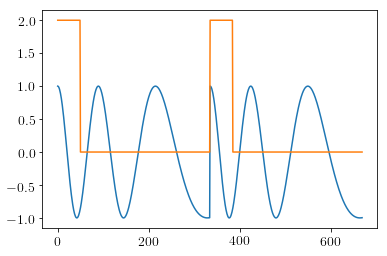

In [157]:
tEnd = 3.35
t = np.linspace(0, tEnd, 335)
w = chirp(t, f0= 1.25, f1= 0.25, t1= tEnd, method='linear') # the chirp signal
u = 2* np.concatenate((np.ones([1,50])[0], np.zeros((1,285))[0])) # the input pulse

2.852924, 0.50

repeatTime = 30
periodicChirpList = [w]
pulseSigList = [u]

for i in np.arange(repeatTime - 1):
    periodicChirpList.append(w)
    pulseSigList.append(u)

periodicChirp = np.array(periodicChirpList).flatten()    
pulseSig = np.array(pulseSigList).flatten()    


plt.plot(periodicChirp[:2*335])
plt.plot(pulseSig[:2*335])


In [158]:
prediction_dict = {}
mse_dict = {}

for this_trainFile in trainFileList:


    trainDataset = this_trainFile + '.hdf5'
    testDataset = trainDataset

    fileName = os.path.join(folderName, trainDataset)
    h5f = h5py.File(fileName, "r")
    importedData = h5f["data"][:]
    h5f.close()

    data = np.concatenate(importedData, axis = 1)


    data = data[:, :len(periodicChirp)] # match the size of input and target 

    nonzeroNeuronIndices = np.where(np.sum(data, axis = 1) > 1e-10)[0] 
    data = data[nonzeroNeuronIndices, :]


    target = periodicChirp

    
    regr = linear_model.Ridge(alpha = 0) # carry out linear regression

    regr.fit(data.T, target.T)
    coefficients = regr.coef_

    prediction = fitter.sklearn_prevision(regr = regr, matrix = data)

    
    prediction_dict[this_trainFile] = prediction

    mse_dict[this_trainFile] = round(mean_squared_error(prediction_dict[this_trainFile], target),2)

    

In [159]:
mse_dict

{'classificationBias_slowClassificationRes_seqPulse': 0.14,
 'baselineBias_classificationRes_seqPulse': 0.42}

# Visualize results

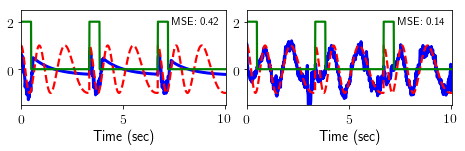

In [173]:
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

# plt.rcParams.update({'font.size': 22})
width = 6.37
height = width / 1.618 / 2
fig = plt.figure()
# fig.subplots_adjust(left=.06, bottom=.16, right=.99, top=.97)
ax1 = fig.add_subplot(121)

nrPeriods = 3


ax1.plot(np.arange(nrPeriods * 335)/100, prediction_dict['baselineBias_classificationRes_seqPulse'][0:nrPeriods * 335], color = 'b',linewidth = 3)
ax1.plot(np.arange(nrPeriods * 335)/100, target[:nrPeriods * 335], linestyle = '--', color = 'red', linewidth = 2.2)
ax1.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2.2)

ax1.set_ylim([-1.5, 2.5])
ax1.set_xlim([0, 10.05])
ax1.set_xlabel('Time (sec)')
ax1.text(7.4, 1.9, 'MSE: ' + str(mse_dict['baselineBias_classificationRes_seqPulse']), fontsize=11)

# ax1.set_ylabel('Time (sec)')


ax2 = fig.add_subplot(122)
ax2.plot(np.arange(nrPeriods * 335)/100, prediction_dict['classificationBias_slowClassificationRes_seqPulse'][:nrPeriods * 335], color = 'b', linewidth = 3)
ax2.plot(np.arange(nrPeriods * 335)/100, target[:nrPeriods * 335], linestyle = '--', color = 'red',  linewidth = 2.2)
ax2.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2.2)
ax2.set_ylim([-1.5, 2.5])
ax2.set_xlim([0, 10.05])
ax2.text(7.4, 1.9, 'MSE: ' + str(mse_dict['classificationBias_slowClassificationRes_seqPulse']), fontsize=11)

ax2.set_xlabel('Time (sec)')


fig.set_size_inches(width, height)
fig.subplots_adjust(left=.04, bottom=.05, right=.98, top=.97)

plt.subplots_adjust(bottom = 0.3, wspace=0.1)
plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_regression.pdf', dpi=1200)

plt.show()



In [111]:
round(mean_squared_error(prediction_dict['baselineBias_classificationRes_seqPulse'][0:nrPeriods * 335], target[:nrPeriods * 335]),2) 




0.41

In [110]:
round(mean_squared_error(prediction_dict['classificationBias_slowClassificationRes_seqPulse'][0:nrPeriods * 335], target[:nrPeriods * 335]),2)
                   
                   

0.19